In [74]:
# We start by importing some modules:
import uproot  # reads the data in the binary .root files
import awkward as ak  # provides "ragged" arrays for n-dimensional arrays with variables lengths
import vector  # defines classes for manipulating, e.g. four-vectors
import boost_histogram as bh # for filling hisograms
import matplotlib.pyplot as plt  # for visualising histograms and other plots
import numpy as np 
import numba # "just-in-time" compiling of complex functions

In [75]:
events = uproot.open("Run2012C_DoubleMuParked.root:Events")
# events = uproot.open("SMHiggsToZZTo4L.root:Events")
events.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
run                  | int32_t                  | AsDtype('>i4')
luminosityBlock      | uint32_t                 | AsDtype('>u4')
event                | uint64_t                 | AsDtype('>u8')
PV_npvs              | int32_t                  | AsDtype('>i4')
PV_x                 | float                    | AsDtype('>f4')
PV_y                 | float                    | AsDtype('>f4')
PV_z                 | float                    | AsDtype('>f4')
nMuon                | uint32_t                 | AsDtype('>u4')
Muon_pt              | float[]                  | AsJagged(AsDtype('>f4'))
Muon_eta             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_phi             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_mass            | float[]                  | AsJagged(AsDtype('>f4'))
Muon_charge       

In [94]:

@numba.njit
def find_4lep(events_leptons, builder):
    """Search for valid 4-lepton combinations from an array of events * leptons {charge, ...}

    A valid candidate has two pairs of leptons that each have balanced charge
    Outputs an array of events * candidates {indices 0..3} corresponding to all valid
    permutations of all valid combinations of unique leptons in each event
    (omitting permutations of the pairs)
    """
    for leptons, lep_charge in zip(events_leptons, events_leptons.charge):
        builder.begin_list()
        nlep = len(leptons)
        for i0 in range(nlep):
            for i1 in range(i0 + 1, nlep):
                if lep_charge[i0] + lep_charge[i1] != 0:
                    continue
                for i2 in range(nlep):
                    for i3 in range(i2 + 1, nlep):
                        if len({i0, i1, i2, i3}) < 4:
                            continue
                        if lep_charge[i2] + lep_charge[i3] != 0:
                            continue
                        builder.begin_tuple(4)
                        builder.index(0).integer(i0)
                        builder.index(1).integer(i1)
                        builder.index(2).integer(i2)
                        builder.index(3).integer(i3)
                        builder.end_tuple()
        builder.end_list()

    return builder

vector.register_awkward()

def RunSamples(samples):
    print("Running samples {}".format(samples))
    res = {
        "hist_all": bh.Histogram(bh.axis.Regular(10, -0.5, 9.5)),
        "hist_filtered": bh.Histogram(bh.axis.Regular(10, -0.5, 9.5)),
        "hist_ncharged": bh.Histogram(bh.axis.Regular(4, -0.5, 3.5), bh.axis.Regular(4, -0.5, 3.5)),
        "h_mz1_before": bh.Histogram(bh.axis.Regular(50, 0, 250)),
        "h_mz2_before": bh.Histogram(bh.axis.Regular(50, 0, 250)),
        "h_m4l": bh.Histogram(bh.axis.Regular(36, 70, 180)),
        "h_mz1": bh.Histogram(bh.axis.Regular(36, 40, 160)),
        "h_mz2": bh.Histogram(bh.axis.Regular(36, 12, 160)),
        "h_eta": bh.Histogram(bh.axis.Regular(50, 0, 10))
    }

    for branches in uproot.iterate(samples, step_size="10 MB", filter_name=["Muon*","event"]):
        branches = branches[ak.num(branches["Muon_pt"]) == 4]

        muons = ak.zip({
            "pt": branches["Muon_pt"],
            "eta": branches["Muon_eta"],
            "phi": branches["Muon_phi"],
            "mass": branches["Muon_mass"],
            "charge": branches["Muon_charge"],
            "pfRelIso04_all": branches["Muon_pfRelIso04_all"],
            "dxy": branches["Muon_dxy"],
            "dz": branches["Muon_dz"],
            "dxyErr": branches["Muon_dxyErr"],
            "dzErr": branches["Muon_dzErr"]
            }, with_name="Momentum4D")

        muons["ip3d"] = np.sqrt(muons.dxy * muons.dxy + muons.dz * muons.dz)
        muons["sip3d"] = muons.ip3d / np.sqrt(muons.dxyErr * muons.dxyErr + muons.dzErr * muons.dzErr)
        muon_selecton = (
            (muons.pt > 5) & (np.abs(muons.eta) < 2.4) & 
            (np.abs(muons.pfRelIso04_all) < 0.4) & 
            (muons.sip3d < 4) & (np.abs(muons.dxy) < 0.5) & (np.abs(muons.dz) < 1.0)
            )
        res["hist_all"].fill(ak.num(muons))
            
        muons = muons[muon_selecton]

        res["h_eta"].fill(ak.flatten(muons.sip3d))

        muon_counts = (ak.num(muons) == 4) & (ak.num(muons[muons.charge == 1]) == 2) & (ak.num(muons[muons.charge == -1]) == 2)
        muons = muons[muon_counts]

        res["hist_ncharged"].fill(ak.num(muons[muons.charge == 1]), ak.num(muons[muons.charge == -1]))
        res["hist_filtered"].fill(ak.num(muons))

        if (len(muons) == 0):
            continue
        fourmuon = find_4lep(muons, ak.ArrayBuilder()).snapshot()
        fourmuon = [muons[fourmuon[idx]] for idx in "0123"]
        fourmuon = ak.zip({
            "z1": ak.zip({
                "lep1": fourmuon[0],
                "lep2": fourmuon[1],
                "p4": fourmuon[0] + fourmuon[1],
            }),
            "z2": ak.zip({
                "lep1": fourmuon[2],
                "lep2": fourmuon[3],
                "p4": fourmuon[2] + fourmuon[3],
            }),
        })

        # Better way???
        # fourmuon_sel = (fourmuon.z1.p4.mass > 40.) & (fourmuon.z1.p4.mass < 120.) & (fourmuon.z2.p4.mass > 12.) & (fourmuon.z2.p4.mass < 120.) & (fourmuon.z1.lep1.deltaR(fourmuon.z1.lep2) > 0.02) & (fourmuon.z2.lep1.deltaR(fourmuon.z2.lep2) > 0.02)
        # fourmuon = fourmuon[fourmuon_sel]
        # min_fourmuon = ak.num(fourmuon) > 0
        # fourmuon = fourmuon[min_fourmuon]
        # events = events[min_fourmuon]
        # print(events.to_list())
        # bestz1 = ak.singletons(ak.argmin(abs(fourmuon.z1.p4.mass - 91.1876), axis=1))
        # fourmuon = ak.flatten(fourmuon[bestz1])

        # alt way
        bestz1 = ak.singletons(ak.argmin(abs(fourmuon.z1.p4.mass - 91.1876), axis=1))
        fourmuon = ak.flatten(fourmuon[bestz1])
        res["h_mz1_before"].fill(fourmuon.z1.p4.mass)
        res["h_mz2_before"].fill(fourmuon.z2.p4.mass)

        fourmuon_sel = (fourmuon.z1.p4.mass > 40.) & (fourmuon.z1.p4.mass < 120.) & (fourmuon.z2.p4.mass > 12.) & (fourmuon.z2.p4.mass < 120.) & (fourmuon.z1.lep1.deltaR(fourmuon.z1.lep2) > 0.02) & (fourmuon.z2.lep1.deltaR(fourmuon.z2.lep2) > 0.02)
        fourmuon = fourmuon[fourmuon_sel]

        res["h_m4l"].fill((fourmuon.z1.p4 + fourmuon.z2.p4).mass)
        res["h_mz1"].fill(fourmuon.z1.p4.mass)
        res["h_mz2"].fill(fourmuon.z2.p4.mass)
    return res

h_data = RunSamples(["Run2012B_DoubleMuParked.root:Events", "Run2012C_DoubleMuParked.root:Events"])
h_bkg = RunSamples(["ZZTo4mu.root:Events"])
h_sig = RunSamples(["SMHiggsToZZTo4L.root:Events"])

scaleFactorZZTo4l = 1.386
integratedLuminosity = 11.58 * 1000.0
for h in h_bkg.values():
    h *= (0.077 / 1499064.0 * scaleFactorZZTo4l * integratedLuminosity)
for h in h_sig.values():
    h *= (0.0065 / 299973.0 * integratedLuminosity)

Running samples ['Run2012B_DoubleMuParked.root:Events', 'Run2012C_DoubleMuParked.root:Events']
Running samples ['ZZTo4mu.root:Events']
Running samples ['SMHiggsToZZTo4L.root:Events']


[0. 0. 0. 0. 1. 4. 9. 5. 3. 1. 1. 0. 0. 1. 2. 0. 1. 0. 1. 0. 0. 0. 1. 0.
 3. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1.]


/var/folders/63/smjwcwgs2mvdq9xx4_7pt4th0000gp/T/ipykernel_7470/2892538593.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


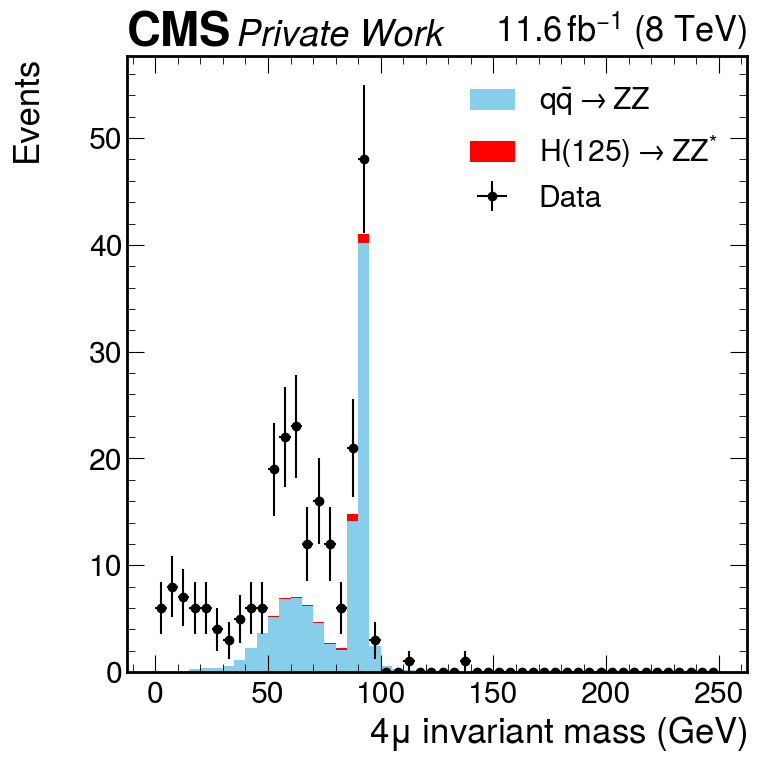

In [96]:
import mplhep as hep
hep.style.use("CMS")
fig, ax = plt.subplots(figsize=(8,8))
print(h_data["h_m4l"].values())
draw="h_mz1_before"
hep.histplot(
   [h_bkg[draw], h_sig[draw]],
   stack=True,
   # bins=bins,
   histtype="fill",
   color=["skyblue", "red"],
   alpha=[1, 1],
   # edgecolor=["k", "red"],
   label=[
       r"$q\bar{q}\rightarrow ZZ$",
       r"H(125)$ \rightarrow ZZ^{*}$",
   ],
   ax=ax,
   flow="none",
   linestyle="solid"
)

ax.errorbar(
   h_data[draw].axes[0].centers,
   h_data[draw].values(),
   xerr=h_data[draw].axes[0].widths / 2.,
   yerr=np.sqrt(h_data[draw].values()),
   linestyle="None",
   color="black",
   marker="o",
   label="Data"
)
# hep.cms.label(rlabel=r"$11.6\,fb^{-1}$ (8 TeV)")
hep.cms.text("Private Work")
hep.cms.lumitext(r"$11.6\,fb^{-1}$ (8 TeV)")
ax.legend()
rmin = 70
rmax = 181
ax.set_xlabel(r"4$\mu$ invariant mass (GeV)", fontsize=25)
ax.set_ylabel("Events\n", fontsize=25)
# ax.set_xlim(70, 180)
# plt.yscale('log')
fig.show()

In [93]:
edges = list(h_sig["h_m4l"].axes[0].edges)
# print(edges.find(120))
print(h_sig["h_m4l"].axes[0].edges)

import bisect
idx_l = bisect.bisect_left(edges, 120) - 1
idx_r = bisect.bisect_left(edges, 130)
print(edges[idx_l], edges[idx_r])
print(idx_l, idx_r)
print(np.sum(h_sig["h_m4l"].values()[idx_l:idx_r]))
print(np.sum(h_bkg["h_m4l"].values()[idx_l:idx_r]))
print(np.sum(h_data["h_m4l"].values()[idx_l:idx_r]))

[ 70.          73.05555556  76.11111111  79.16666667  82.22222222
  85.27777778  88.33333333  91.38888889  94.44444444  97.5
 100.55555556 103.61111111 106.66666667 109.72222222 112.77777778
 115.83333333 118.88888889 121.94444444 125.         128.05555556
 131.11111111 134.16666667 137.22222222 140.27777778 143.33333333
 146.38888889 149.44444444 152.5        155.55555556 158.61111111
 161.66666667 164.72222222 167.77777778 170.83333333 173.88888889
 176.94444444 180.        ]
118.88888888888889 131.11111111111111
16 20
2.144384394595514
1.5268041174492886
2.0


[0. 0. 0. 0. 1. 4. 9. 5. 3. 1. 1. 0. 0. 1. 2. 0. 1. 0. 1. 0. 0. 0. 1. 0.
 3. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1.]
<bound method Histogram.values of Histogram(Regular(50, 0, 250), storage=Double()) # Sum: 100.83007796368935 (101.2365112411745 with flow)>


/Users/Andrew/Code/PHY307-HandsOn/.venv/lib/python3.9/site-packages/mplhep/utils.py:240: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/var/folders/63/smjwcwgs2mvdq9xx4_7pt4th0000gp/T/ipykernel_7470/4220788617.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


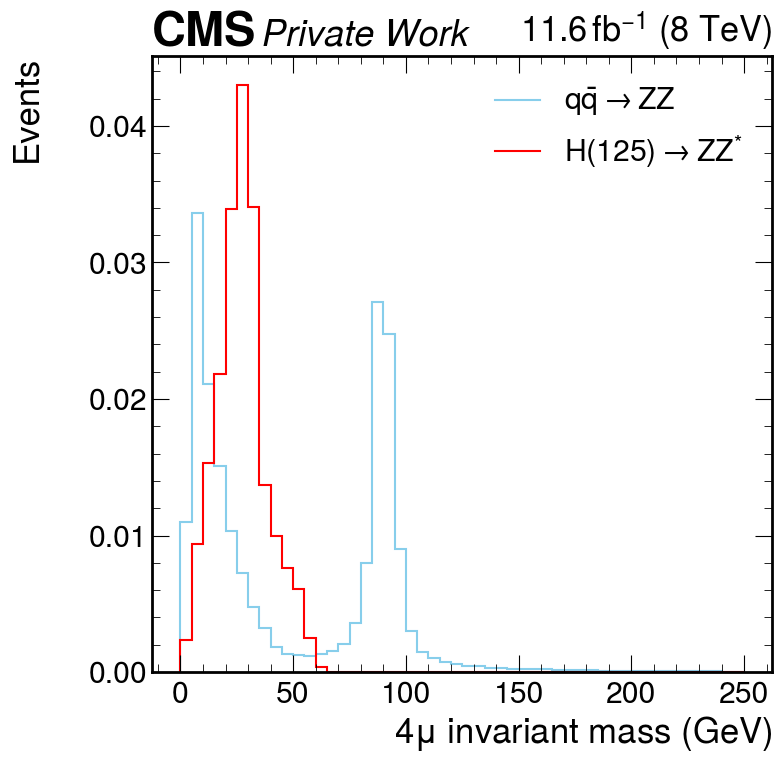

In [105]:
import mplhep as hep
hep.style.use("CMS")
fig, ax = plt.subplots(figsize=(8,8))
print(h_data["h_m4l"].values())
draw="h_mz2_before"
hep.histplot(
   [h_bkg[draw] * (1. / h_bkg[draw].sum()), h_sig[draw] * (1. / h_sig[draw].sum())],
   stack=False,
   # bins=bins,
   histtype="step",
   color=["skyblue", "red"],
   alpha=[1, 1],
   # edgecolor=["k", "red"],
   label=[
       r"$q\bar{q}\rightarrow ZZ$",
       r"H(125)$ \rightarrow ZZ^{*}$",
   ],
   ax=ax,
   flow="none",
   linestyle="solid",
   binwnorm=1
)
print(h_bkg[draw].values())

# hep.cms.label(rlabel=r"$11.6\,fb^{-1}$ (8 TeV)")
hep.cms.text("Private Work")
hep.cms.lumitext(r"$11.6\,fb^{-1}$ (8 TeV)")
ax.legend()
rmin = 70
rmax = 181
ax.set_xlabel(r"4$\mu$ invariant mass (GeV)", fontsize=25)
ax.set_ylabel("Events\n", fontsize=25)
# ax.set_xlim(70, 180)
# plt.yscale('log')
fig.show()